# 卒論 均等クラスタリング

## Introduction
### 背景

新型コロナウイルスでの療養対応にあたり、限られた医療リソースを効率良く使うために、最適なヘルパーと患者のマッチングが必要。

- 自宅療養の場合、療養者全体がP
- ヘルパーを何人配置すれば、１人１人のヘルパーの負担が均等になり、また全ての療養者が早めに対応してもらえるか？
- チャレンジ：療養者が随時に増減（体調などの状況も変化）するから一回のクラスタリングすればよいような静的なアルゴリズムは向かない


### 問題

- オブジェクト集合Pをk個のクラスタC1, …, Ckに分ける。ただし
- クラスタCi内において、ロードL(Ci)を定義、計算
- 各クラスタの間、ロードLが等しい（差がなるべく小さい）ようにする
- （物理的な上限L0を超えない：　L(Ci)≦L0）←今回は考えない？
- 上記制約のもと、全てのクラスタに関して、上記のロードLの和+kBが最小となるk (Bがペナルティ)


クラスタCにおけるロードL(C) は何がいいか？
1. Cの分散（標準偏差）sd(C), L(C)=|C|+sd(C)
2. クラスタCのL：L(C)=|C|+log(C内のペアごとのユークリッド距離和)  ←問題あり

### 既存アルゴリズム

- K-means
- Balanced K-means
- X-means


## 実験方法

### 検証
 - 当てはまり度
 - 実行速度

## 解法

#### 手法1 k-means 漸近的に
k-meansでLをもとめる。ある程度の数になるまで実行し、どのKのときにLが最小化するか

#### 手法2 x-means
わからない


## 環境
- Julia 1.6.3



## Julia installed, sandbox

In [1]:
f(x) = x, x^2
double(max) = [f(n) for n=1:max]




double (generic function with 1 method)

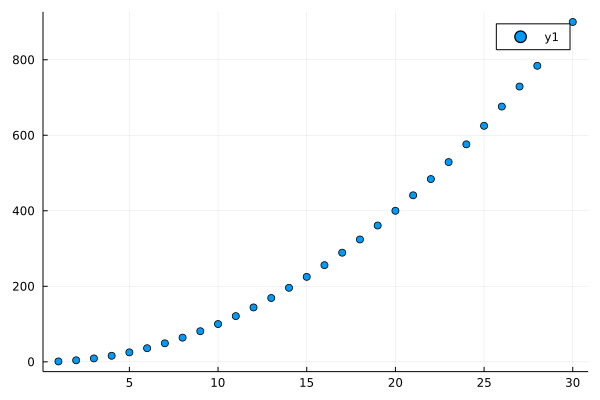

In [2]:
using Plots

plot(double(30), st=:scatter, )

## 手法1

### データの用意
- iris (150 row)
  - PetalLength, PetalWidth
- quakes (1000 row)
  - Earthqueakes of Fiji
  - long, lat

In [3]:
# 

### 解く
問題 `SumL + kB` を最小化するような`k`を見つける。

#### L(C)を定義する
- L(C)=|C|+sd(C), Cの分散
- 分散がベクトルなので、足し合わせる。

#### Basic Penalty
penaltyはデータの特性、外部要件により調整.

#### アルゴリズム
1. k=1の時に、 各L(Ci)の差が最小となる組み合わせをみつける。
    - 標準のk-meansを適用する。
        - k-means++
        - クラスタCiの中心からの距離の和が最小とするような、クラスタをみつける
        - k個のクラスタと各クラスタCiの中心が得られる
        - 問題：k-meansだとロードLが等しい（差がなるべく小さい）ようにするの成約が無効？一旦置いとく。
            - 理由：一回で計算されてしまうから。あとは初期値を変えて試すか、L(C)の条件を加味しないといけない？
    - L(Ci) を計算する 
    - クラスタ間のLiから分散: varianceLを計算する　(負担が均等かの評価に使おうと思ったが k-meansだけだと使わない？）
        - 配列 [L(Ci) for i=1:k ] 
        - 平均L~を計算
        - varianceL = 1/k * Sum (Li - L~)^2
    - 
2. k=k+1 をして、1を十分な回数繰り返す。
    - ”十分な数”を定数で決めておく
3. 解
    - ~varianceLが最小のkが優勝~
    - SumLが最小のkが優勝


In [70]:
using RDatasets, Clustering, Plots, Statistics, DataFrames

5×5 DataFrame
 Row │ Lat      Long     Depth  Mag      Stations 
     │ Float64  Float64  Int64  Float64  Int64    
─────┼────────────────────────────────────────────
   1 │  -20.42   181.62    562      4.8        41
   2 │  -20.62   181.03    650      4.2        15
   3 │  -26.0    184.1      42      5.4        43
   4 │  -17.97   181.66    626      4.1        19
   5 │  -20.42   181.96    649      4.0        11


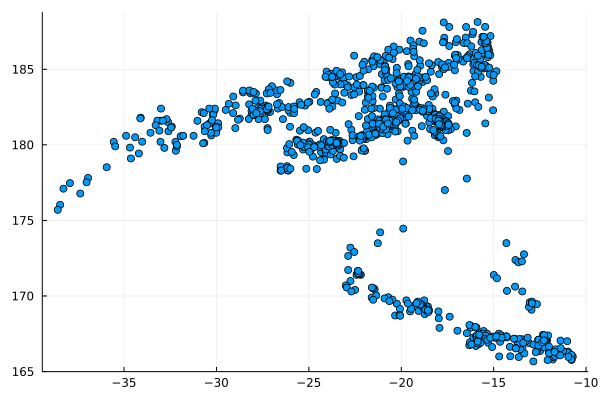

In [260]:
iris = dataset("datasets", "iris"); # load the data
# features = collect(Matrix(iris[:, 1:2])')

quakes = dataset("datasets", "quakes"); # load the data

println(first(quakes, 5))


features = collect(Matrix(quakes[:, 1:2])')

scatter(quakes.Lat, quakes.Long,
        legend=false)

In [293]:
# Algorithm

function retriveCluster(data, cluster_idx, asm)
    return [data[i,:] for i=1:size(data,1) if asm[i] == cluster_idx]
end

function calcLoad(cluster)
    return reduce(+, Statistics.var(cluster)) + size(cluster,1)
end

function findClusters(data, k=1, basic_penalty=1)
    # k-means
    R = kmeans(data, k; maxiter=200, display=:none)

    a = assignments(R) # get the assignments of points to cluster
    c = counts(R) # get the cluster sizes
    nclust = nclusters(R)
    M = R.centers # get the cluster centers

    # calc L(C) of all Cluster
    
    data_t = transpose(data)
    loads = []
    for i=1:nclust
        cluster = retriveCluster(data_t, i, a)
        load = calcLoad(cluster)
        push!(loads, load)
    end
    
    # calc variance of L of all Cluster
    varL = Statistics.var(loads)
    
    # calc sum L + kB, B is penalty
    sumL = reduce(+, loads) + k * basic_penalty
    
   
    return a,c,M, sumL, varL
end

findClusters (generic function with 3 methods)

1: sumL: 1065.127528785886, varL: NaN
2: sumL: 1048.5929493340507, varL: 179284.7964672885
3: sumL: 1050.7888430086514, varL: 31126.160432047043
4: sumL: 1046.5723224456217, varL: 44174.04343976675
5: sumL: 1055.2780215675887, varL: 13023.414273408005
6: sumL: 1051.1168897326697, varL: 14144.845290356363
7: sumL: 1054.4489996078369, varL: 6333.844342805621
8: sumL: 1056.5459964988531, varL: 7788.263244234302
9: sumL: 1056.4910849211144, varL: 1481.9477355078943
10: sumL: 1061.9891076574013, varL: 2747.1415167947134
11: sumL: 1063.2473424548873, varL: 3605.6883530606256
12: sumL: 1062.6587158966815, varL: 2284.479997792824
13: sumL: 1066.1975013417295, varL: 2052.647872646776
14: sumL: 1067.797803719288, varL: 2060.6060383412314
15: sumL: 1071.4161957200715, varL: 1422.8551650631402
16: sumL: 1072.8618078469758, varL: 933.8156640604807
17: sumL: 1079.6982162972258, varL: 1510.4938643726687
18: sumL: 1078.7030717694768, varL: 1277.632345347629
19: sumL: 1082.4477163014164, varL: 629.2500

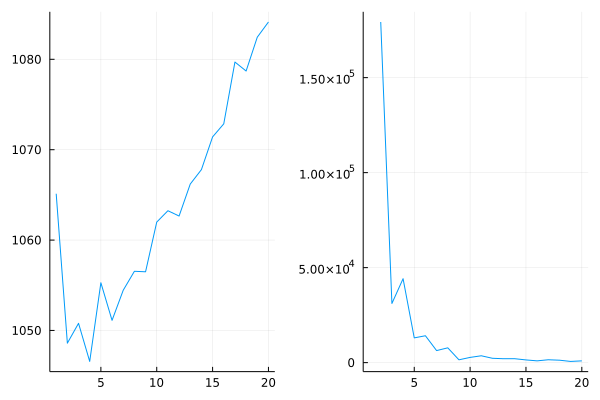

In [296]:
# test

basic_penalty = 3

# find k that minimaize sumL
sums = []
varLs = []
prots = []
for k=1:20
    a,c,M, sumL, varL = findClusters(features, k, basic_penalty)
    println("$k: sumL: $sumL, varL: $varL")
    push!(sums, sumL)
    push!(varLs, varL)
    
    # plot sclustering
    prot = scatter(quakes.Lat, quakes.Long, marker_z=a,
        color=:lightrainbow, legend=false)
    push!(prots, prot)
    
end

minL, minK = findmin(sums)
println("minK: $minK, L: $minL")
p1 = plot(sums, legend=false, title="Sum of Loads")
p2 = plot(varLs, legend=false, title="variance of Loads")

plot(p1,p2)


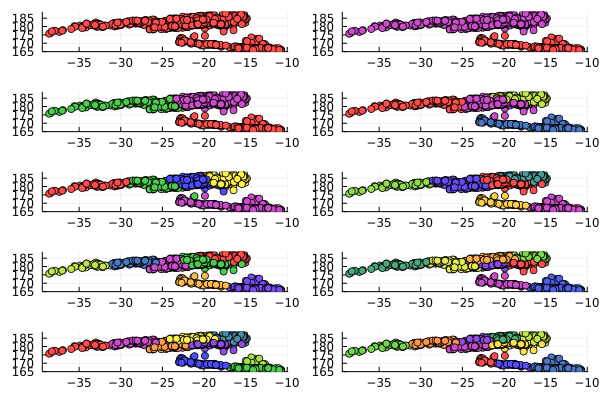

In [271]:
# plot clustering
plot(prots..., layout=(5,2))